# HW01

# 2 Two-dimensional data

In [1]:
%%capture

from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.nn.modules import loss
from torch import optim
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from tqdm.auto import tqdm

In [2]:
torch.manual_seed(0)

## 2.1 MLP

In [21]:
class MyModel1D(torch.nn.Module):
    def __init__(self):
        super(MyModel1D, self).__init__()
        self.thetas = torch.zeros(200, requires_grad=True)

    def forward(self, x):
        return torch.exp(self.thetas[x]) / torch.sum(torch.exp(self.thetas))
    
    def parameters(self):
        return [self.thetas]
    
    def __call__(self, x):
        return self.forward(x)

In [22]:
class MLPModel(torch.nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(200, 200),
            nn.Softmax()
        )

    def forward(self, x):
        return self.model(x)
    
    def parameters(self):
        return self.model.parameters()
    
    def __call__(self, x):
        return self.forward(x)

In [31]:
class MyModel2D(torch.nn.Module):
    def __init__(self):
        super(MyModel2D, self).__init__()
        self.my_model_1d = MyModel1D()
        self.mlp_model = MLPModel()
        
    def forward(self, x):
        x1, x2 = x[:,0], x[:,1]
        
        p1 = self.my_model_1d(x1)
        one_hot = torch.zeros((x.shape[0], 200))
        one_hot[np.arange(x.shape[0]), x1] = 1
        model_p = self.mlp_model(one_hot)
        p2 = model_p[np.arange(x.shape[0]), x2]
        p = p1 * p2

        return p
    
    def parameters(self):
        return list(self.mlp_model.parameters()) + self.my_model_1d.parameters()
    
    def __call__(self, X):
        return self.forward(X)

In [25]:
def MyNLLLoss(y):
    return -torch.sum(torch.log(y))

In [33]:
def sample_data():
    distribution = np.load('./distribution.npy')
    distribution_ravel = distribution.ravel()
    size = distribution.shape[0]
    pairs = np.array([[(i, j) for j in np.arange(size)] for i in np.arange(size)], dtype=np.int64)
    idx = np.random.choice(np.arange(len(distribution_ravel)), 100000, p=distribution_ravel)
    idx_2d = np.unravel_index(idx, distribution.shape)
    samples = pairs[idx_2d]
    return samples

In [29]:
def fit(model, X_train, X_val, X_test, optimizer, loss_function, epoch_cnt, batch_size):
    val_size = len(X_val)
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
    train_loss_values = []
    val_loss_values = []
        
    for epoch in tqdm(range(epoch_cnt)):
        for batch_data in train_loader:
            optimizer.zero_grad()
            output = model(batch_data)
            loss = loss_function(output)
            train_loss_values.append(loss / 2 / batch_size)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            output = model(X_val)
            loss = loss_function(output)
            val_loss_values.append(loss / 2 / val_size)

    with torch.no_grad():
        output = model(X_test)
        loss = loss_function(output)
        print("Test set loss: {:.6f}".format(loss / 2 / len(X_test)))

    return train_loss_values, val_loss_values 


In [34]:
samples = sample_data()
X_train, X_test = train_test_split(samples, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.125, random_state=42)

In [35]:
model = MyModel2D()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
loss_function = MyNLLLoss

In [36]:
epoch_cnt = 20
batch_size = 1000
train_loss_values, val_loss_values =\
    fit(model, X_train, X_val, X_test, optimizer, loss_function, epoch_cnt, batch_size)

C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Test set loss: 5.313879


In [37]:
def plot_loss_values(train_loss_values, val_loss_values):
    plt.plot(np.arange(len(train_loss_values)), train_loss_values, color='blue', label='train')
    plt.plot(np.arange(0, len(train_loss_values), len(train_loss_values) / epoch_cnt), val_loss_values, color='red', label='validation')
    plt.legend()
    plt.title("Loss values")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()

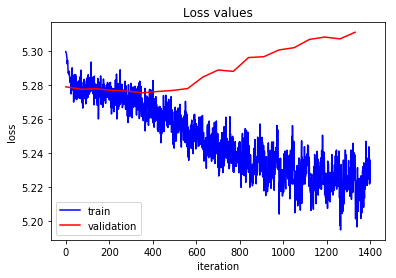

In [38]:
plot_loss_values(train_loss_values, val_loss_values)

(40000, 2)
[[2.4617606e-05 1.8249031e-05 1.8777026e-05 ... 2.3894969e-05
  2.0170895e-05 3.6841615e-05]
 [2.1250569e-05 3.5144443e-05 2.2177406e-05 ... 3.3305721e-05
  2.1826987e-05 1.6534796e-05]
 [1.9038156e-05 3.3059008e-05 1.7515176e-05 ... 2.5014719e-05
  3.0730971e-05 2.8798473e-05]
 ...
 [1.5637845e-05 3.9824565e-05 1.8945511e-05 ... 1.0786455e-05
  1.8134382e-05 4.4112236e-05]
 [1.7055650e-05 2.5775233e-05 1.4708688e-05 ... 8.9729447e-06
  1.5583122e-05 1.9648916e-05]
 [1.1771787e-05 9.1790953e-06 1.0307445e-05 ... 9.3174804e-06
  2.0075107e-05 1.9359475e-05]]


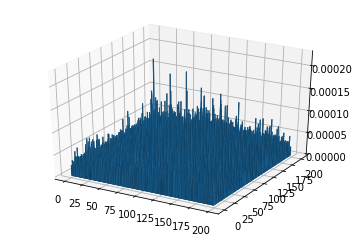

In [52]:
from mpl_toolkits.mplot3d import Axes3D
x = np.array([[(i, j) for j in np.arange(200)] for i in np.arange(200)], dtype=np.int64)
x = x.reshape(-1, 2)
model_p = model(x)
model_p = model_p.detach().numpy()
model_p = model_p.reshape((200, 200))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(np.arange(200), np.arange(200), bins=200)

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = np.ones_like(zpos)
dz = model_p.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.show()

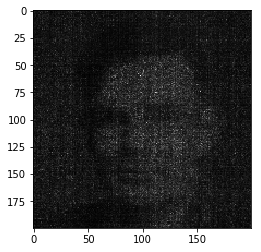

In [55]:
plt.imshow(model_p, cmap='gray')

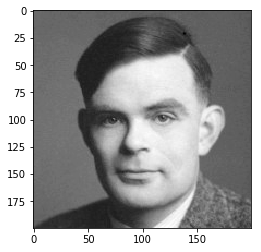

In [56]:
plt.imshow(np.load('./distribution.npy'), cmap='gray')

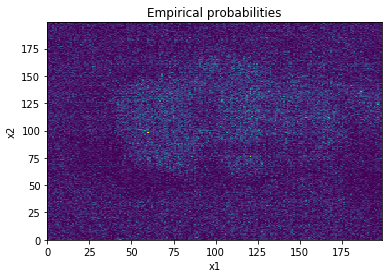

In [70]:
model_p_ravel = model_p.ravel()
size = 200
pairs = np.array([[(i, j) for j in np.arange(size)] for i in np.arange(size)], dtype=np.int64)
idx = np.random.choice(np.arange(len(model_p_ravel)), 100000, p=model_p_ravel / model_p_ravel.sum())
idx_2d = np.unravel_index(idx, model_p.shape)
samples = pairs[idx_2d]

plt.hist2d(samples[:,0], samples[:,1], bins=200, range=np.array([[0,199], [0,199]]))
plt.title("Empirical probabilities")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

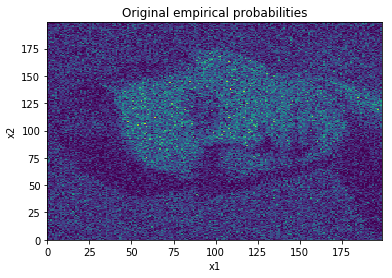

In [68]:
samples = sample_data()

plt.hist2d(samples[:,0], samples[:,1], bins=200, range=np.array([[0,199], [0,199]]))
plt.title("Original empirical probabilities")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## 2.1 MADE